
# Forecast de Vendas de Champanhe

***

<img src="https://media.gazetadopovo.com.br/bomgourmet/2018/12/degustacao-champagne-768x307-48964f10.jpg" alt="Champagne Sales" title="Venda de Champanhe" />

***


#### A previsão de vendas,  é um procedimento que busca fazer estimativa das vendas de uma empresa em um determinado período futuro.

#### Nesse sentido, ela pode antecipar quantas vendas serão concluídas, quanto de faturamento será alcançado, e até mesmo como será a evolução do funil de vendas, tomando como base vários fatores internos e externos ao negócio. Alguns desses fatores podem ser as variações de mercado, o investimento em publicidade e até mesmo a época do ano.

#### Como se trata de uma previsão, muitas vezes os resultados não são exatamente iguais ao esperado. Porém, o importante é que a diferença entre o realizado e o previsto não seja muito grande, já que a previsão de vendas serve como o parâmetro para a maioria das atividades no meio comercial. É com base na previsão que o gestor avalia, por exemplo, se precisa contratar mais mão de obra para entregar o produto/serviço vendido.



In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from math import sqrt
from math import floor
from itertools import product
import statsmodels.api as sm
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.linear_model import LinearRegression
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.tree import DecisionTreeRegressor
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster
from sklearn.neighbors import KNeighborsRegressor
import warnings

In [143]:
warnings.filterwarnings("ignore")

In [144]:
plt.rcParams["figure.figsize"] = (20,5)

In [145]:
def dickey_fuller_test(serie):
    print('Resutaldo do Teste Dickey-Fuller:')
    dftest = adfuller(serie, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', '# de lags', '# de observações'])
    dfoutput['Stationary'] = True if dftest[1]<=0.05 else False
    for key, value in dftest[4].items():
        dfoutput['Valores Críticos ({})'.format(key)] = value
    try:
        pd.Series(serie).plot()
    except Exception:
        serie.plot()
    pyplot.show
    print(dfoutput)

In [146]:
def difference(dataset, interval=1):
  diff = list() 
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

def inverse_difference(history, previsao, interval=1):
  return previsao + history[-interval]

In [147]:
def best_window_value(serie):
    window_score = {}
    for i in range(3,(len(serie)//2)+1):
        rolling = serie.rolling(window=i).mean().astype('float64')
        window_score[i] = sqrt(mean_squared_error(serie.shift(1).iloc[i:].astype('float64'), rolling.iloc[i:]))
    return sorted(window_score, key = window_score.get)[0]

In [148]:
def plot_graphs(serie1,serie2=pd.Series(),erro=None):
    if erro!=None:
        print(erro)
    serie1.plot(color = '#1f77b4')
    if not serie2.empty:
        serie2.plot(color='red')
    pyplot.show

In [149]:
def grid_search(func,serie,ncombinations=6,intervalo=None,print_values=False):
    combinations_score = {}
    for combination in list(product([i for i in range(0,ncombinations+1)], repeat=3)):
        erro = ''
        try:
            if intervalo:
                erro = func(serie,combination,intervalo=intervalo)[2]
            else:
                erro = func(serie,combination)[2]
            combinations_score[combination] = erro
        except Exception:
            erro = 'Error'
        if print_values:
            print(combination,'-',erro)
    return sorted(combinations_score, key = combinations_score.get)[0]

In [150]:
def grid_search_sarima(serie,ncombinations=3,intervalo=12,print_values=False):
    combinations_score = {}
    for combination1 in list(product([i for i in range(0,ncombinations+1)], repeat=3)):
        for combination2 in list(product([i for i in range(0,ncombinations+1)], repeat=3)):
            erro = ''
            try:
                erro = predict_sarima_test(serie,combination1,combination2,intervalo=intervalo)[2]
                combinations_score[(str(combination1)+' - '+str(combination2))] = erro
            except Exception:
                erro = 'Error'
            if print_values:
                print(combination1,'-',combination2,'-',erro)
    return sorted(combinations_score, key = combinations_score.get)[0]

In [151]:
def predict_arima_test(serie,order_arima,ptrain=0.75):
    size = int(len(serie)*ptrain)
    train = list(serie.iloc[:size])
    test = list(serie.iloc[size:])
    predictions =[]
    for value in test:
        model = ARIMA(train,order=order_arima).fit(disp=0)
        predictions += [float(model.forecast()[0])]
        train += [value]
    test = pd.Series(test,index=serie.iloc[size:].index)
    predictions = pd.Series(predictions,index=serie.iloc[size:].index)
    return test,predictions,sqrt(mean_squared_error(test,predictions))

In [152]:
def predict_arima_diff_test(serie,order_arima,ptrain=0.75,intervalo=12):
    size = int(len(serie)*ptrain)
    train = list(serie.iloc[:size])
    test = list(serie.iloc[size:])
    predictions =[]
    real = []
    for value in test:
        diff = difference(train, intervalo)
        model = ARIMA(diff,order=order_arima).fit(trend='nc',disp=0)
        predictions += [inverse_difference(train, float(model.forecast()[0]), intervalo)]
        train += [value]
    test = pd.Series(test,index=serie.iloc[size:].index)
    predictions = pd.Series(predictions,index=serie.iloc[size:].index)
    #print(sqrt(mean_squared_error(test,predictions)))
    return test,predictions,sqrt(mean_squared_error(test,predictions))

In [153]:
def predict_sarima_test(serie,order_arima,seasonal_order,ptrain=0.75,intervalo=12):
    size = int(len(serie)*ptrain)
    train = list(serie.iloc[:size])
    test = list(serie.iloc[size:])
    predictions =[]
    for value in test:
        model = sm.tsa.statespace.SARIMAX(train, 
                                          order=order_arima, 
                                          seasonal_order=(seasonal_order[0],seasonal_order[1],seasonal_order[2], intervalo))\
                                          .fit(trend='nc', disp=0)
        predictions += [float(model.forecast()[0])]
        train += [value]
    test = pd.Series(test,index=serie.iloc[size:].index)
    predictions = pd.Series(predictions,index=serie.iloc[size:].index)
    return test,predictions,sqrt(mean_squared_error(test,predictions))

In [154]:
def linear_regression_test(serie,ptrain=0.75,window_length=12):
    size = int(len(serie)*ptrain)
    train = serie.iloc[:size]
    test = serie.iloc[size:]
    fh = ForecastingHorizon(test.index, is_relative=False)
    linreg = LinearRegression()
    linreg_forecaster = ReducedRegressionForecaster(linreg, window_length=window_length).fit(train)
    y_linreg_pred = linreg_forecaster.predict(fh)
    return test,y_linreg_pred,sqrt(mean_squared_error(test,y_linreg_pred))

In [155]:
def decision_tree_regression_test(serie,ptrain=0.75,window_length=12):
    size = int(len(serie)*ptrain)
    train = serie.iloc[:size]
    test = serie.iloc[size:]
    fh = ForecastingHorizon(test.index, is_relative=False)
    dtr = DecisionTreeRegressor()
    dtr_forecaster = ReducedRegressionForecaster(dtr, window_length=window_length).fit(train)
    y_dtr_pred = dtr_forecaster.predict(fh)
    return test,y_dtr_pred,sqrt(mean_squared_error(test,y_dtr_pred))

In [156]:
def auto_arima_test(serie,ptrain=0.75,sp=12):
    size = int(len(serie)*ptrain)
    train = serie.iloc[:size]
    test = serie.iloc[size:]
    fh = ForecastingHorizon(test.index, is_relative=False)
    arima_forecasting = AutoARIMA(sp=sp).fit(train)
    y_arima = arima_forecasting.predict(fh)
    return test,y_arima,sqrt(mean_squared_error(test,y_arima))

In [157]:
def naive_forecaster_test(serie,ptrain=0.75,strategy="last",sp=12):
    size = int(len(serie)*ptrain)
    train = serie.iloc[:size]
    test = serie.iloc[size:]
    fh = ForecastingHorizon(test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy=strategy, sp=sp).fit(train)
    y_pred = forecaster.predict(fh)
    return test,y_pred,sqrt(mean_squared_error(test,y_pred))

In [158]:
def k_neighbors_regression_test(serie,ptrain=0.75,n_neighbors=3,strategy="recursive",window_length=12):
    size = int(len(serie)*ptrain)
    train = serie.iloc[:size]
    test = serie.iloc[size:]
    fh = ForecastingHorizon(test.index, is_relative=False)
    regressor = KNeighborsRegressor(n_neighbors=n_neighbors)
    forecaster = ReducedRegressionForecaster(regressor=regressor, 
                                             window_length=window_length, 
                                             strategy=strategy)\
                                             .fit(train)
    y_pred = forecaster.predict(fh)
    return test,y_pred,sqrt(mean_squared_error(test,y_pred))

In [159]:
def exponential_smoothing_test(serie,ptrain=0.75,periods=12,trend='additive',seasonal='additive',use_boxcox=True):
    size = int(len(serie)*ptrain)
    train = serie.iloc[:size]
    test = serie.iloc[size:]
    
    exponential_smoothing_fit = ExponentialSmoothing(train, seasonal_periods=periods, trend=trend, seasonal=seasonal).fit(use_boxcox=use_boxcox)
    exponential_smoothing_forecast = exponential_smoothing_fit.forecast(len(test))
    return test,exponential_smoothing_forecast,sqrt(mean_squared_error(test,exponential_smoothing_forecast))

In [160]:
def create_residuals(test,predictions):
    residuals = [test[i] - predictions[i] for i in range(len(test))]
    residuals = pd.Series(residuals,index=test.index)
    return residuals

# Analise dos dados

Análises de dados é a atividade de transformar um conjunto de dados com o objetivo de poder verificá-los melhor dando-lhes um sentido. É analisar os dados de um problema e identificá-los. Podemos verificar que este conjunto de dados contém um campo de data e um campo de quantidade de champanhe vendida em dólares naquele período, sendo a data segmentada por meses do ano.

In [161]:
serie = pd.read_csv('champagne_sales.csv',
                    delimiter=',',
                    header=0,
                    index_col=0,
                    squeeze=True,
                    parse_dates=True)

In [162]:
serie = serie.resample('M').sum()
serie

Month
1964-01-31    2815
1964-02-29    2672
1964-03-31    2755
1964-04-30    2721
1964-05-31    2946
              ... 
1972-05-31    4618
1972-06-30    5312
1972-07-31    4298
1972-08-31    1413
1972-09-30    5877
Freq: M, Name: Sales, Length: 105, dtype: int64

In [163]:
serie.describe()

count      105.000000
mean      4761.152381
std       2553.502601
min       1413.000000
25%       3113.000000
50%       4217.000000
75%       5221.000000
max      13916.000000
Name: Sales, dtype: float64

Text(0.5, 0, 'Data')

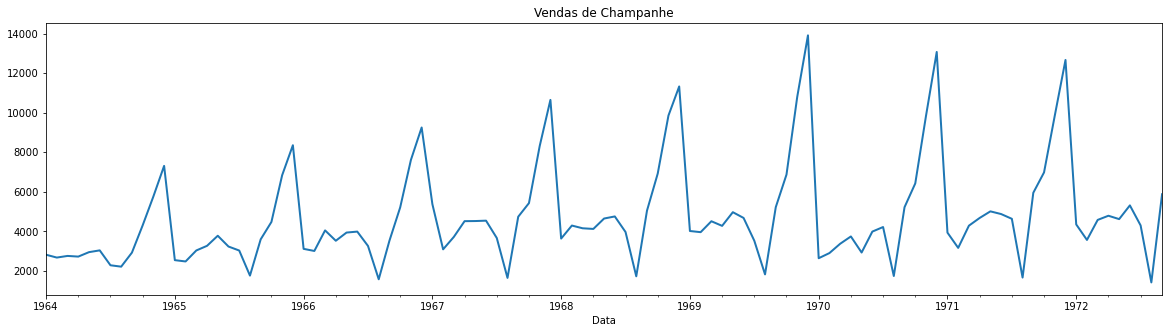

In [164]:
serie.plot(linewidth=2,
           fontsize=10,
           title='Vendas de Champanhe')
plt.xlabel('Data',fontsize=10)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

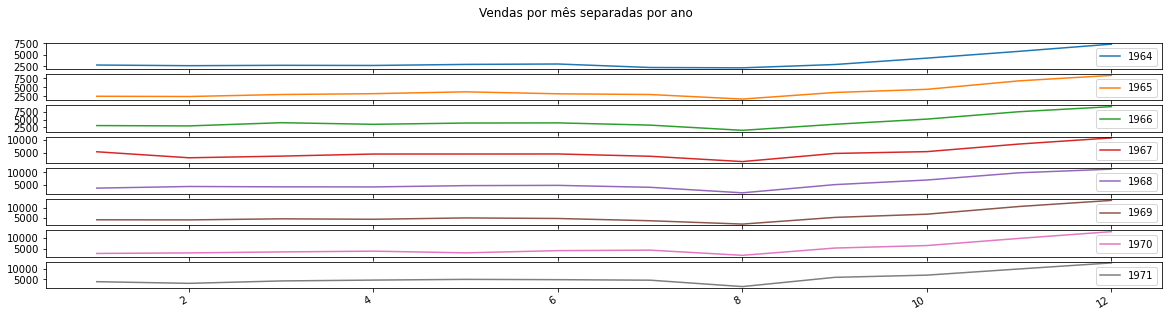

In [165]:
subset_serie = serie.copy()
subset_serie.drop(serie['1972'].index,inplace=True)
year_groups = subset_serie.groupby(pd.Grouper(freq="A"))
year_freq = pd.DataFrame()

for name, year_group in year_groups:
    year_freq[name.year] = year_group.values
year_freq.index = year_freq.index+1

year_freq.plot(subplots=True,
               title='Vendas por mês separadas por ano')

# Distribuição e correlação

A distribuição de frequência é um arranjo de valores que uma ou mais variáveis tomam em uma amostra. Cada entrada na tabela contém a frequência ou a contagem de ocorrências de valores dentro de um grupo ou intervalo específico, e deste modo, a tabela resume a distribuição dos valores da amostra. Podemos ver que os dados seguem uma distribuição de gaussiana.

A autocorrelação é a correlação cruzada de um sinal com o ele próprio. É uma ferramenta matemática para encontrar padrões de repetição, tal como a presença de um sinal periódico obscurecidos pelo ruído, ou para identificar a frequência fundamental em falta num sinal implícita pelas suas frequências harmónicas. É frequentemente utilizada no processamento de sinais para a análise de funções ou série de valores, como por exemplo sinais no domínio do tempo. Onde esse conjunto de dados possui uma alta correlação com dados de anos anteriores em relação ao mês que se analisa.

<AxesSubplot:ylabel='Density'>

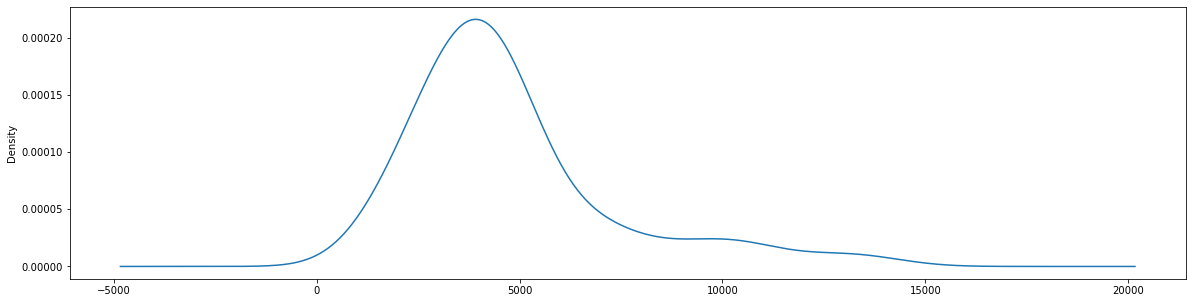

In [166]:
serie.plot(kind='kde')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

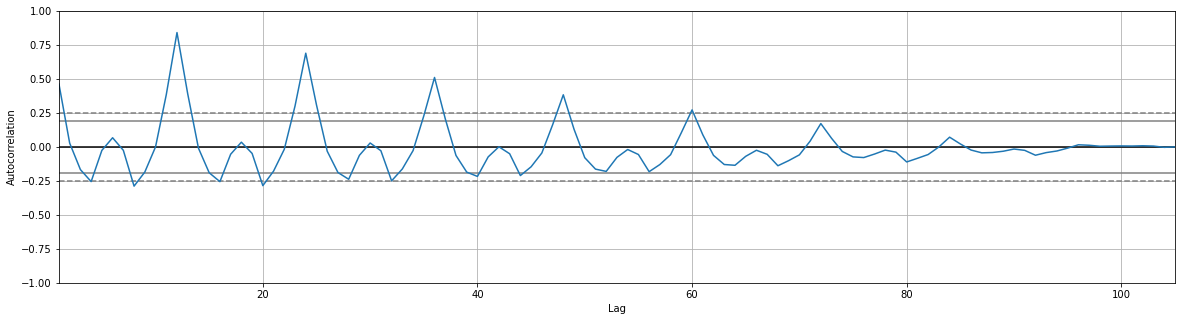

In [167]:
autocorrelation_plot(serie)

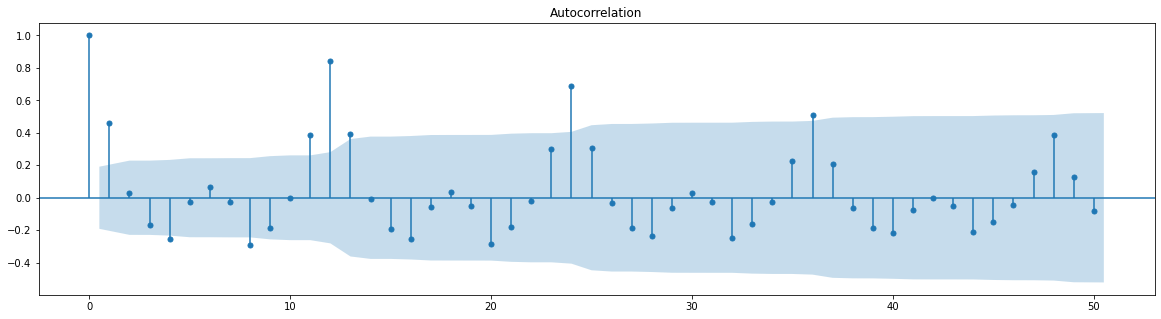

In [168]:
plot_acf(serie,lags=50)
pyplot.show()

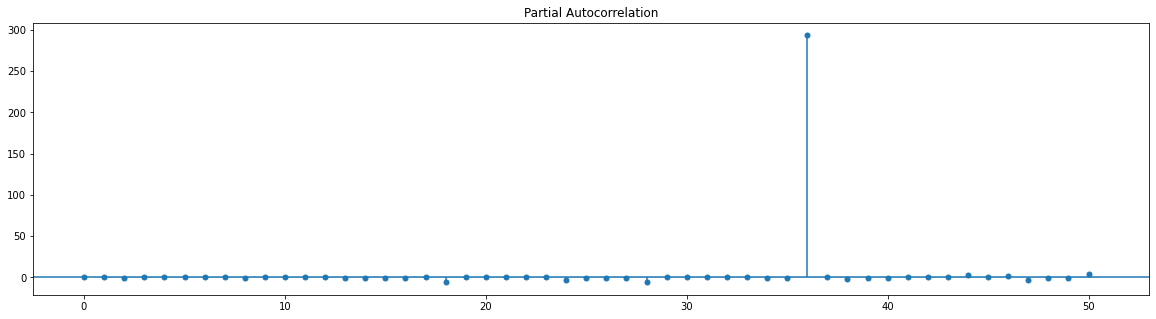

In [169]:
plot_pacf(serie,lags=50)
pyplot.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 12)'>

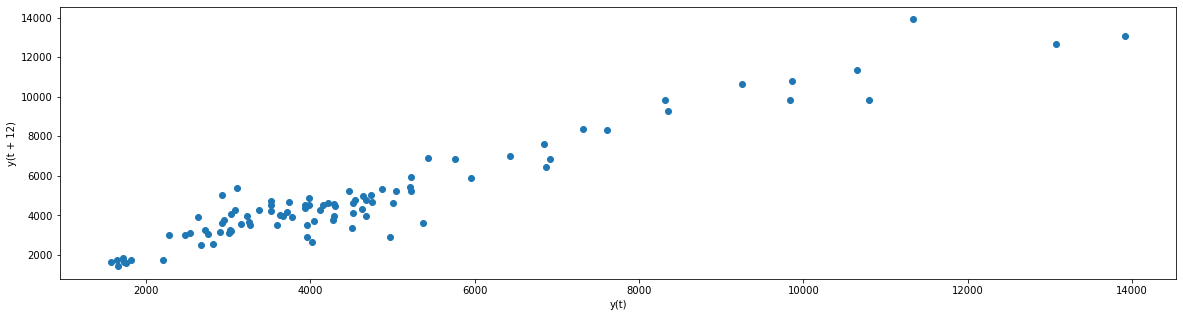

In [170]:
lag_plot(serie,lag=12)

# Decomposição de Serie Temporais

Uma série temporal é uma coleção de observações feitas sequencialmente ao longo do tempo, a ordem dos dados é fundamental. Uma característica muito importante deste tipo de dados é que as observações vizinhas são dependentes e o interesse é analisar e modelar essa dependência.

Componentes de uma Série Temporal:
- **Tendência**: Tendência é a direção geral de alguma coisa que está se desenvolvendo ou evoluindo no eixo do tempo.
- **Sazonalidade**: É qualquer mudança ou padrão previsível em uma série temporal.
- **Resíduo**: É o comportamento aleatório, ou seja, tudo o que sobra após retirar a sazonalidade e tendência da série.

#### **Modelo aditivo**

                      y(t) = Level + Trend + Seasonality + Noise

  - Os componentes se somam.
  - A amplitude da sazonalidade se mantém com um aumento da tendência.


#### **Modelo multiplicativo**

                      y(t) = Level × Trend × Seasonality × Noise
                
  - Os componentes se multiplicam.
  - A amplitude da sazonalidade também aumenta com a tendência

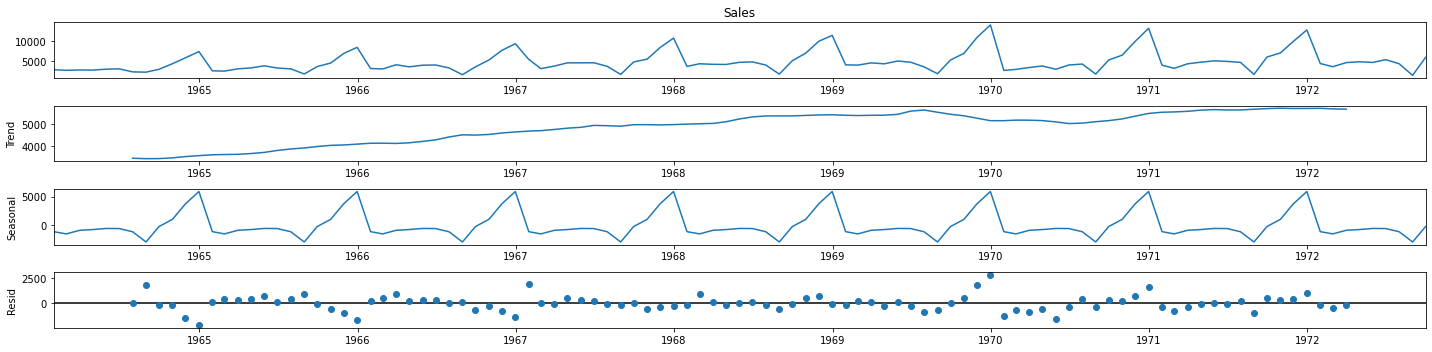

In [171]:
seasonal_decompose_result = seasonal_decompose(serie, model='additive')
seasonal_decompose_result.plot()
pyplot.show()

# Série Estacionária

Uma série estacionária é o que em matemática costuma se chamar série convergente, ou seja, aquela que flutua em torno de uma mesma média ao longo do tempo.

O teste de Dickey-Fuller foi criado para verificar se um modelo autorregressivo tem ou não raiz unitária.

Resutaldo do Teste Dickey-Fuller:
Teste                     -1.833593
Valor p                    0.363916
# de lags                 11.000000
# de observações          93.000000
Stationary                 0.000000
Valores Críticos (1%)     -3.502705
Valores Críticos (5%)     -2.893158
Valores Críticos (10%)    -2.583637
dtype: float64


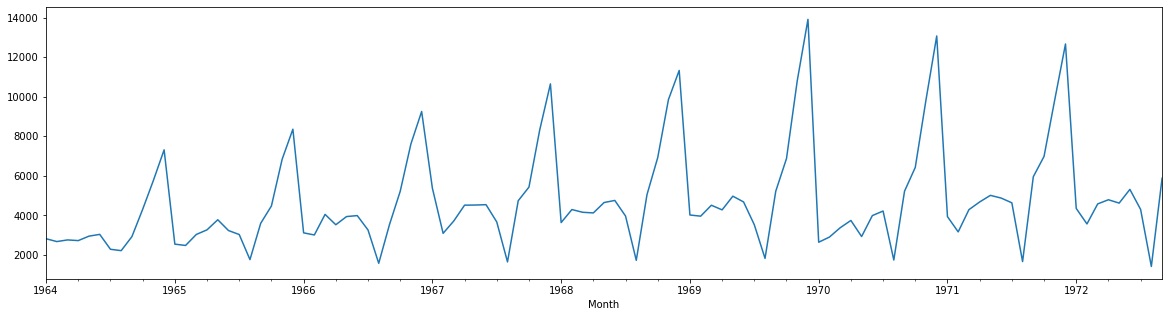

In [172]:
dickey_fuller_test(serie)

Resutaldo do Teste Dickey-Fuller:
Teste                     -2.255119
Valor p                    0.186852
# de lags                 13.000000
# de observações          91.000000
Stationary                 0.000000
Valores Críticos (1%)     -3.504343
Valores Críticos (5%)     -2.893866
Valores Críticos (10%)    -2.584015
dtype: float64


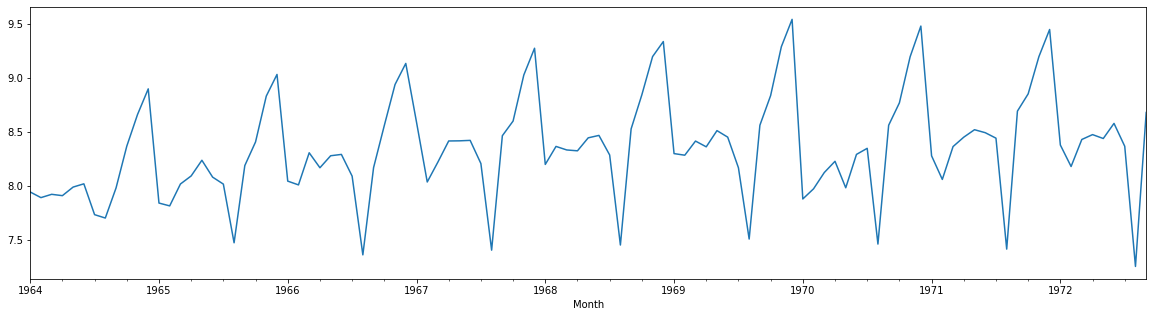

In [173]:
dickey_fuller_test(np.log(serie))

Resutaldo do Teste Dickey-Fuller:
Teste                    -7.189896e+00
Valor p                   2.519620e-10
# de lags                 1.100000e+01
# de observações          9.200000e+01
Stationary                1.000000e+00
Valores Críticos (1%)    -3.503515e+00
Valores Críticos (5%)    -2.893508e+00
Valores Críticos (10%)   -2.583824e+00
dtype: float64


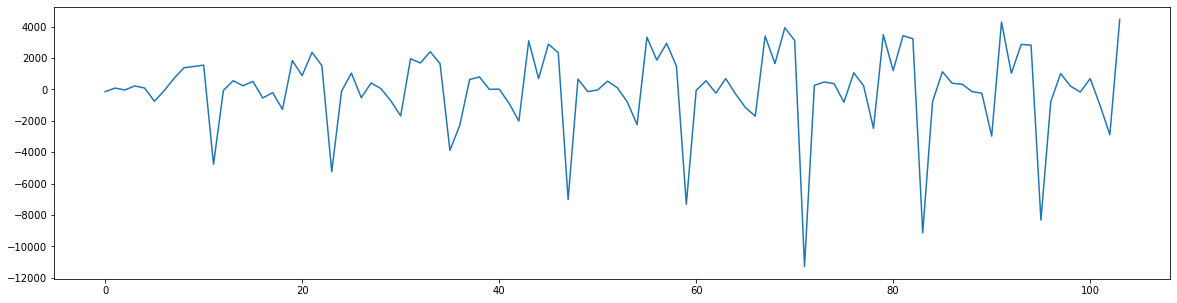

In [174]:
dickey_fuller_test(np.diff(serie))

Resutaldo do Teste Dickey-Fuller:
Teste                    -7.626619e+00
Valor p                   2.060580e-11
# de lags                 0.000000e+00
# de observações          9.200000e+01
Stationary                1.000000e+00
Valores Críticos (1%)    -3.503515e+00
Valores Críticos (5%)    -2.893508e+00
Valores Críticos (10%)   -2.583824e+00
dtype: float64


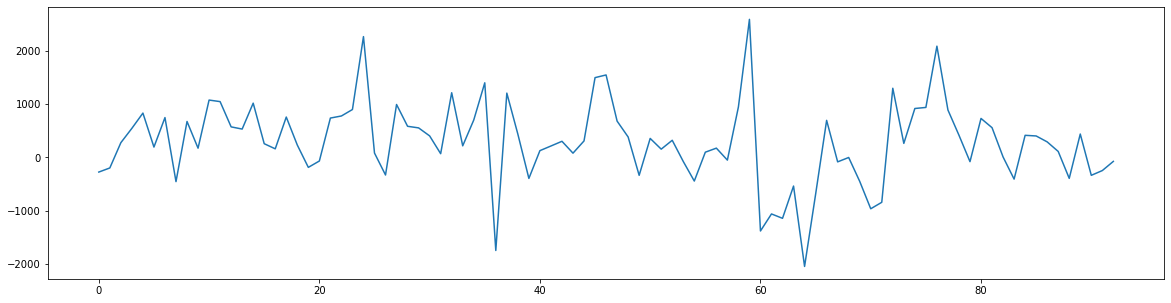

In [175]:
dickey_fuller_test(difference(serie,12))

In [176]:
best_window_value(serie)

3

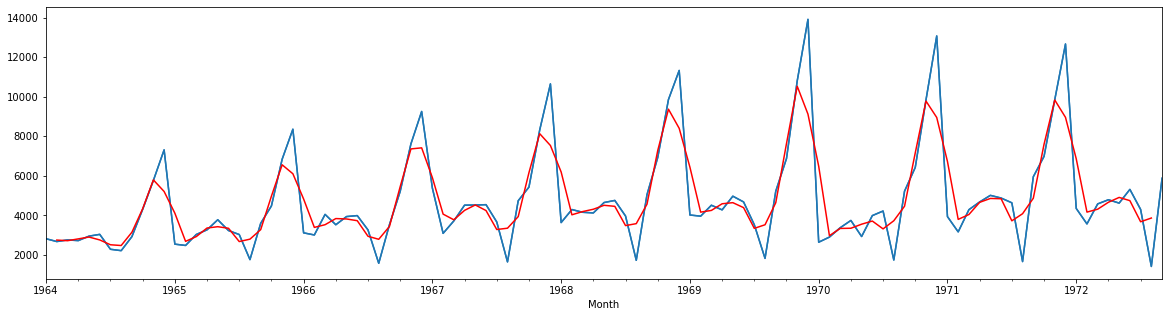

In [177]:
serie.plot()
rolling = serie.rolling(window=best_window_value(serie)).mean().shift(-1)
plot_graphs(serie,rolling)

# Forecast de Vendas e Analise de Modelos

Previsão, em estatística é o processo de estimativas em situações de incertezas. O termo previsão é semelhante, porém mais geral, e normalmente se refere a estimação de séries temporais ou dados instantâneos. Portanto, as previsões são processos críticos e contínuos necessários para obter bons resultados no planejamento de um projeto.

In [179]:
print(grid_search(predict_arima_test,serie))

(0, 0, 5)


2528.4426662862124


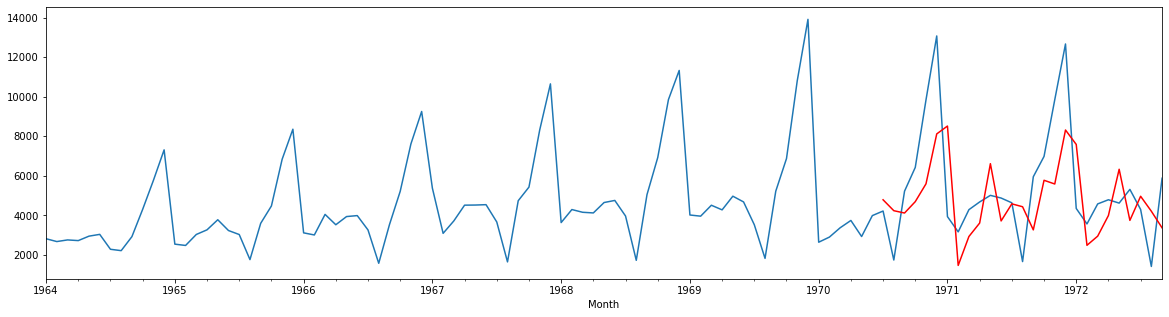

In [180]:
test,predict,erro = predict_arima_test(serie,(0,0,5))
plot_graphs(serie,predict,erro)

1974.2360226347055


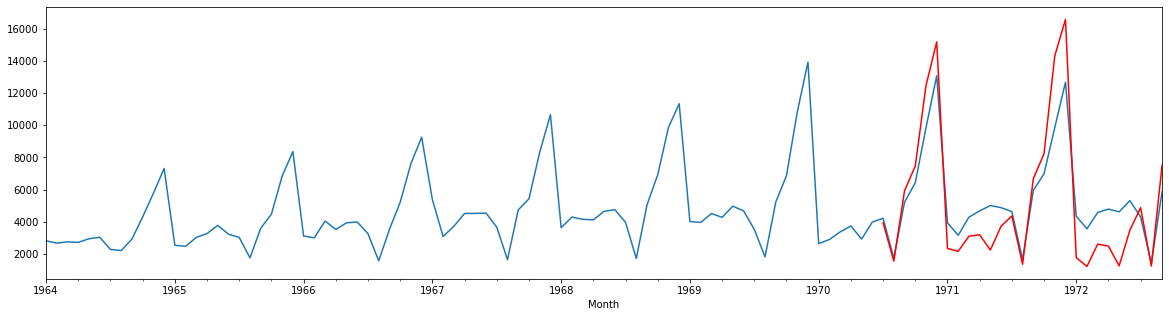

In [186]:
test,predict,erro = linear_regression_test(serie)
plot_graphs(serie,predict,erro)

1291.7193394278231


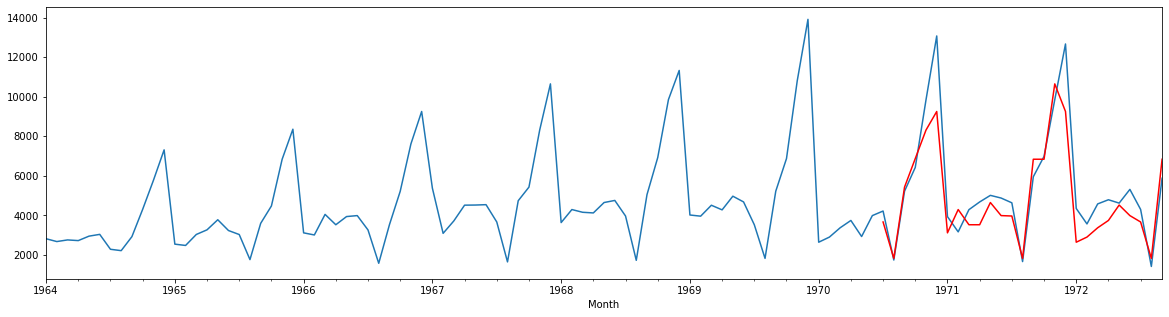

In [187]:
test,predict,erro = decision_tree_regression_test(serie)
plot_graphs(serie,predict,erro)

998.1380072322071


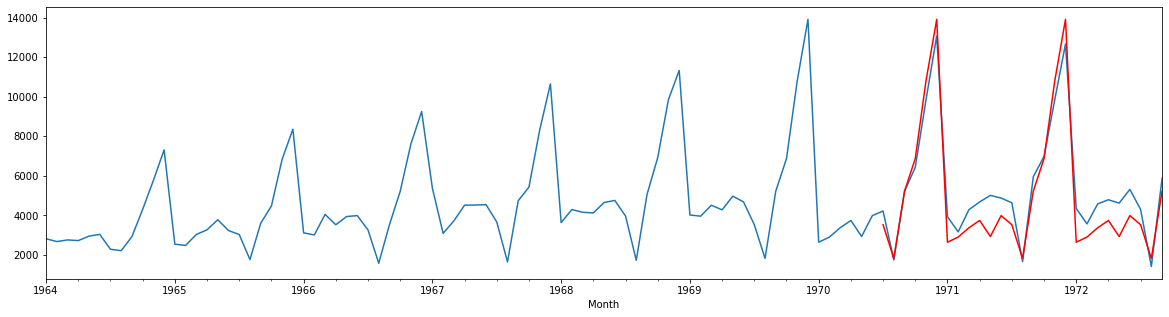

In [189]:
test,predict,erro = naive_forecaster_test(serie)
plot_graphs(serie,predict,erro)

889.9740172914784


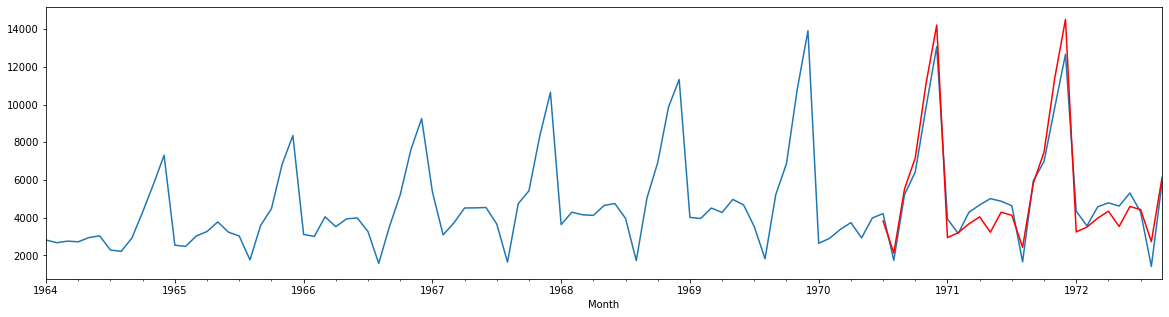

In [188]:
test,predict,erro = auto_arima_test(serie)
plot_graphs(serie,predict,erro)

605.169509974246


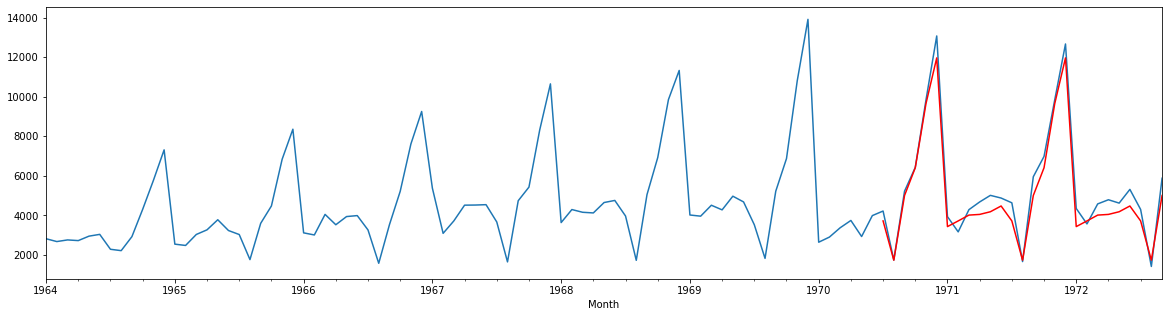

In [190]:
test,predict,erro = k_neighbors_regression_test(serie)
plot_graphs(serie,predict,erro)

In [181]:
print(grid_search(predict_arima_diff_test,serie,intervalo=12))

604.3588405181852


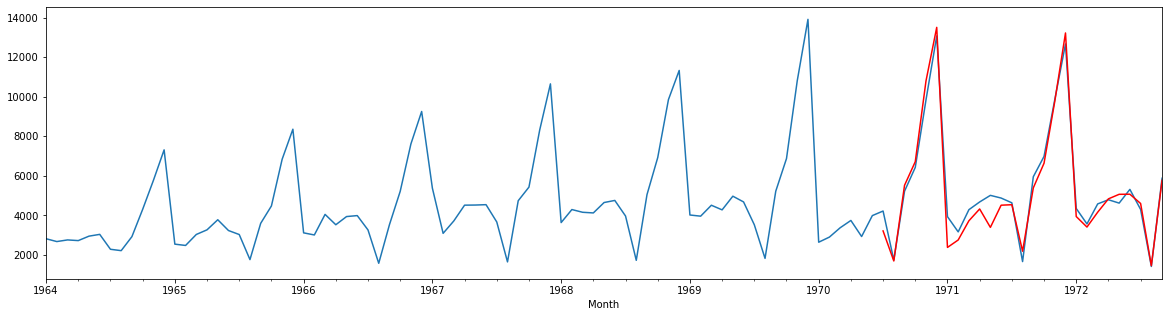

In [182]:
test,predict,erro = predict_arima_diff_test(serie,(6,0,4))
plot_graphs(serie,predict,erro)

In [183]:
print(grid_search_sarima(serie))

585.2099207647829


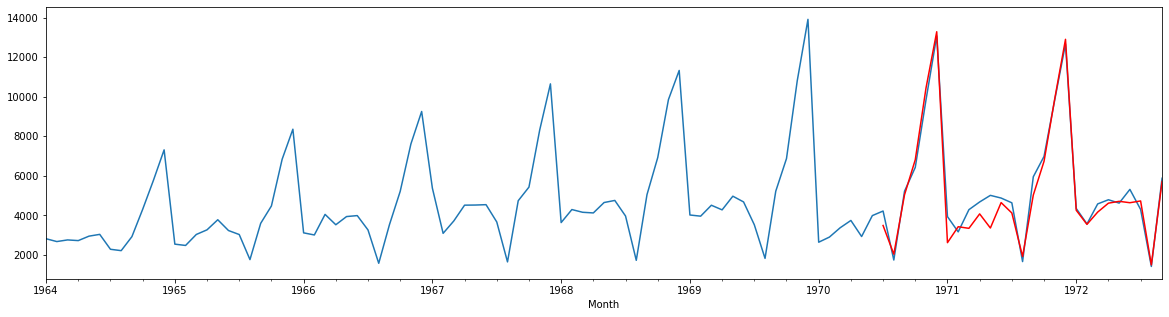

In [184]:
test,predict,erro = predict_sarima_test(serie,(0, 0, 1),(1, 0, 1))
plot_graphs(serie,predict,erro)

421.4073131446144


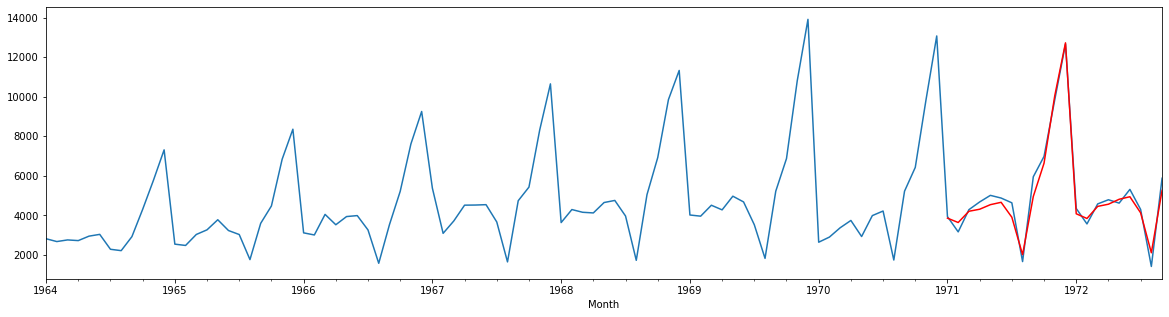

In [193]:
test,predict,erro = exponential_smoothing_test(serie,0.8,12)
plot_graphs(serie,predict,erro)

# Analise de Resíduos

Criar o modelo e verificar o valor do seu resíduo de acordo com a métrica escolhida não é suficiente, é necessário analisar também as características do próprio resíduo, pois há casos em que o modelo não consegue capturar as informações necessárias para se fazer uma boa previsão resultando em um resíduo com “informações na mesa”.

In [194]:
residuals = create_residuals(test,predict)
residuals.describe()

count     21.000000
mean     134.036190
std      409.388989
min     -692.186110
25%     -193.708581
50%      170.899823
75%      368.288747
max      995.578944
dtype: float64

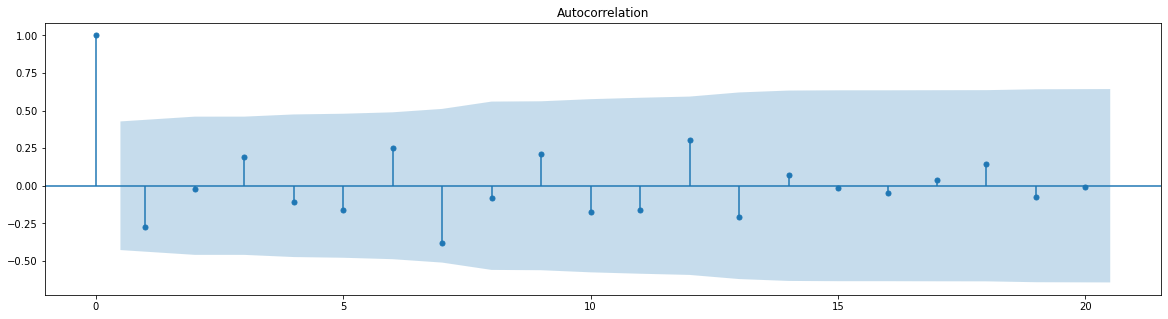

In [195]:
plot_acf(residuals,lags=len(residuals)-1)
pyplot.show()